In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import MetaTrader5 as mt5 # для работы с торговой платформой

import threading # для многопоточности
import pickle # сохранение объектов

from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.metrics import make_scorer #создание метрики
from sklearn import model_selection #методы разделения и валидации

from prophet import Prophet
#from neuralprophet import NeuralProphet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna # для оптимизации гиперпараметров
import pmdarima as pm # для автоматического подбора гиперпараметров

from statsmodels.tsa.arima.model import ARIMA # для модели ARIMA

import datetime as dt
from datetime import datetime

from tqdm import tqdm  # для отображения прогресса долгих рассчетов
tqdm.pandas()

from IPython.display import clear_output # для очистки вывода
import logging # для логирования
import random # для генерации случайных чисел
import winsound  # пищим динамиком, когда надо
import time

pd.options.mode.chained_assignment = None  # для подавления предупреждений

In [2]:
# зададим переменные
random_state = 42
symbol = "EURUSDrfd"
time_delta = 10 * 60 # 10 минут - время, которое нас интересует в качестве предсказания для пипсовой торговли
pips_delta = 0.00025 # 25 пипсов - минимальное изменение цены, которое нас интересует в качестве предсказания для пипсовой торговли (это мы вычислим позже)

In [3]:
# функция, что-бы попищать динамиком. Полезно, что-бы просигналить, что долгий рассчёт окончен

def beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(round(frequency/4), duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(frequency, duration)

# 4. Baseline

In [77]:
# загрузим данные из файла
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target.pkl')

Конечно, ни логистическая регрессия, ни случайный лес - не могут напрямую работать с временным рядом. Поэтому нам придётся для начала преобразовать наш временной ряд в набор признаков для каждой секунды. Т.е. у каждой секунды будут отдельные признаки на каждую предидущие времена (секунды). Но зато мы сразу можем добавить новых признаков. Например, сглаженные средние линии за разные периоды времени. Или линии Боллинжера, или количество операций за последнее время в разные периоды. Это очень сильно разрастёт нашу базу, но зато, поскольку мы более не будем привязаны жестко к временному ряду, мы можем брать каждую 100ю (например) секунду. Что значительно ускорит процесс рассчётов, и не будет сильно влиять на финальный результат, который мы всё равно будет использовать для начальной оценки

Проведем все необходимы преобразования и создания новых признаков

## 4.1 Создание признаков для модели baseline

In [21]:
X = ticks_frame_target.drop('signal', axis=1)
y = ticks_frame_target['signal']

In [ ]:
# Функция для подсчета RSI. Тоже возьмем за признак

def calculate_rsi(prices):
    deltas = np.diff(prices)
    positive_deltas = np.where(deltas > 0, deltas, 0)
    negative_deltas = np.where(deltas < 0, -deltas, 0)    
    avg_gain = np.mean(positive_deltas)
    avg_loss = np.mean(negative_deltas)    
    rs = avg_gain / avg_loss if avg_loss != 0 else 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

Будем считать по скользящим средним, стандартному отклонению и линиям Боллинджера для отрезков в 5 секунд, 1 минута, 5 минут, полчаса и 2 часа.

Причем сами по себе значения средних - нам ничего не дадут. Нам интересна будет разница между последним значением, и скользящим среднем. 
Фактически, мы дифференцируем наш ряд.

Для ускорения - тоже считаем в несколько потоков (библиотека threading)

In [ ]:
t_names = ['bid','ask','time'] # названия колонок для тиковых данных
times_ticks = [5, 60, 5*60, 30*60, 120*60] # временные интервалы скользящих окон для тиков

len_df = len(X) # длина датафрейма


def worker(i): # тоже будем считать в потоках для ускорения

    for t in t_names:
        df_t = X[t].to_numpy() # преобразуем в Numpy. Как показали тесты - Numpy считается значительно быстрее Pandas    

        name_col = t + '_mean_' + str(i) # название колонки
        name_col_std = t + '_std_' + str(i)
        name_col_bol1 = t + '_bol1_' + str(i)
        name_col_bol2 = t + '_bol2_' + str(i)
        name_col_rsi = 'rsi_' + str(i)

        # Создаем пустой массив для хранения результатов
        result = np.empty(len_df)
        result_std = np.empty(len_df)
        result_bol1 = np.empty(len_df)
        result_bol2 = np.empty(len_df)
        result_rsi = np.empty(len_df)
        print (datetime.now().hour,datetime.now().minute,name_col)
        
        for j in range(times_ticks[-1]+1, len_df):
            #x = df[t][j-i:j].copy() # выбрали наше окно
            x = df_t[j-i:j].copy() # выбрали наше окно, исключив из него текущее значение
            t_x = df_t[j] # выбрали наше значения
            sma = np.mean(x)  # среднее значение
            result[j] = sma - t_x
            result_std[j] = np.std(x) # стандартное отклонение
            result_bol1[j] = sma + (2 * result_std[j]) # верхняя полоса Боллинджера
            result_bol2[j] = sma - (2 * result_std[j]) # нижняя полоса Боллинджера
            result_rsi[j] = calculate_rsi(x)            
        
        X[name_col] = result
        X[name_col_std] = result_std
        X[name_col_bol1] = result_bol1
        X[name_col_bol2] = result_bol2
        X[name_col_rsi] = result_rsi

# Создайте список потоков
threads = []

for i in times_ticks:
    thread = threading.Thread(target=worker, args=(i,))
    thread.start()
    threads.append(thread)
    
# Дождитесь завершения всех потоков
for thread in threads:
    thread.join()


10 18 bid_mean_5
10 18 bid_mean_60
10 18 bid_mean_300
10 18 bid_mean_1800
10 18 bid_mean_7200
10 26 ask_mean_5
10 26 ask_mean_60
10 32 time_mean_5
10 33 ask_mean_300
10 34 time_mean_60
10 41 time_mean_300
10 51 ask_mean_1800
10 58 time_mean_1800
11 9 ask_mean_7200
11 13 time_mean_7200


In [ ]:
# сохраним данные в файл (чтобы не пересчитывать каждый раз)
X.to_pickle('pkl/X.pkl')

In [167]:
# загрузим данные из файла
X = pd.read_pickle('pkl/X.pkl')

In [170]:
#Названия колонок сохраним в файл. Нам это понадобится в дальнейшем
colmn = X.columns.tolist()
with open("pkl/columns.pkl", "wb") as f:
    pickle.dump(colmn, f)


Теперь, когда временные признаки учтены для каждой строки датафрейма, можно удалить "лишние строки"

Сначала я оставил столбцы ask, bid и time.
Но тест важности признаков - показал их слишком завышенное значение. Чего, по моему мнению, быть не должно.
Не может прогноз зависить от абсолютного значения числа.

In [24]:
# Удалим признаки ask, bid
X.drop(['ask','bid','time'], axis=1, inplace=True)

## 4.2. Построение baseline-модели

Теперь, когда у нас есть размеченные, и подготовленные данные, попробуем построить первую модель. Поскольку модель случайного леса не требует стандартизации - начнём с неё.

Для начала разобьем базу на тренировочную, и тестовую. Тут, всё еще, надо соблюдать временной ряд, что-бы не случилось утечки. Поэтому в тестовые данные у нас пойдет последняя неделя, а в тренировочные - первые 3

In [25]:
# разобьем данные на 2 части: обучающую и тестовую
# обучающая часть - это данные за первые 3 недели
# тестовая часть - это данные за последнюю неделю

X_train = X.loc['2023-10-01':'2023-10-21']
X_test = X.loc['2023-10-22':'2023-10-31']
y_train = y.loc['2023-10-01':'2023-10-21']
y_test = y.loc['2023-10-22':'2023-10-31']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (1720800, 65)
Размер тестовой выборки: (766799, 65)


In [26]:
# проверим, что соотношение классов в обучающей и тестовой выборке примерно одинаковое
print('Соотношение классов в обучающей выборке:')
print(y_train.value_counts(normalize=True)*100)
print()
print('Соотношение классов в тестовой выборке:')
print(y_test.value_counts(normalize=True)*100)


Соотношение классов в обучающей выборке:
signal
 0    70.185669
 1    15.766097
-1    14.048233
Name: proportion, dtype: float64

Соотношение классов в тестовой выборке:
signal
 0    76.467758
 1    11.997147
-1    11.535096
Name: proportion, dtype: float64


Слегка упало из-за длинных выходных. Но, думаю, это несущественно.

Наконец, построим модель

In [27]:
model = ensemble.RandomForestClassifier(
    #n_estimators=128,
    #max_depth=50,
    #criterion='log_loss',
    #min_samples_leaf=90,
    random_state=random_state,
    #verbose=2,
    class_weight = {-1: 5, 0: 1, 1: 5}, # классы 1 и -1 для нас значимо более важны. Поэтому взвесим их выше
    n_jobs=-1
    )

In [28]:
model.fit(X_train, y_train)
    
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [31]:
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00    241742
           0       1.00      1.00      1.00   1207755
           1       1.00      1.00      1.00    271303

    accuracy                           1.00   1720800
   macro avg       1.00      1.00      1.00   1720800
weighted avg       1.00      1.00      1.00   1720800

              precision    recall  f1-score   support

          -1       0.34      0.17      0.23     88451
           0       0.83      0.95      0.89    586354
           1       0.42      0.23      0.30     91994

    accuracy                           0.78    766799
   macro avg       0.53      0.45      0.47    766799
weighted avg       0.73      0.78      0.74    766799



Главным параметром для нас является Precission. Мы должны давать точный прогноз сигнала, минимизируя ложноположительное срабатывание. Пусть мы упустим большое количество сигналов, но давать ложноположительный сигнал недопустимо - это прямые убытки.

Впрочем, уже сейчас видим, что модель переобучена и неоптимальна. Попробуем подобрать гиперпараметры методом Optuna.

но перед этим попробуем сохратить модель, для ускорения.

In [33]:
X_train = X_train[::100]
y_train = y_train[::100]

# сразу проверим, не потерялись-ли мы в точности, уменьшив выборку

model.fit(X_train, y_train)
    
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2462
           0       1.00      1.00      1.00     12053
           1       1.00      1.00      1.00      2693

    accuracy                           1.00     17208
   macro avg       1.00      1.00      1.00     17208
weighted avg       1.00      1.00      1.00     17208

              precision    recall  f1-score   support

          -1       0.35      0.19      0.24     88451
           0       0.83      0.96      0.89    586354
           1       0.48      0.23      0.31     91994

    accuracy                           0.78    766799
   macro avg       0.56      0.46      0.48    766799
weighted avg       0.74      0.78      0.75    766799



Ничего не потеряли, отлично. Можем продолжать.

## 4.3. Подбор гиперпараметров Optuna

По умолчанию Optuna будет оптимизировать совсем не ту метрику, которая нам нужна, причем основной упор, разумеется, будет делать на класс 0, что нам вообще не интересно.<br> 
Поэтому напишем свою метрику, которая будет учитывать только нужные нам классы. Улучашать будем параметр F1, что-бы в дальнейшем еще немного поднять Precission за счет Recall путем подбора порогового значения

In [ ]:
def my_custom_metric(y_true, y_pred_):
    
    # это метрики, которые я использовал для подбора параметров модели
    # это среднее значение метрик f1 для классов -1 и 1
    metr = (metrics.f1_score(y_true, y_pred_,labels=[-1],average='macro') + metrics.f1_score(y_true, y_pred_,labels=[1],average='macro')) / 2
    
    # это метрики я тоже пробовал, но они не дали прироста качества
    
    #metr = metrics.precision_score(y_true, y_pred_,labels=[0],average='macro')
    #metr = (metrics.precision_score(y_true, y_pred_,labels=[-1],average='macro') + metrics.precision_score(y_true, y_pred_,labels=[1],average='macro')) / 2    
    #metr = ((metrics.f1_score(y_true, y_pred_,labels=[-1],average='macro')*2) +
    #        metrics.f1_score(y_true, y_pred_,labels=[0],average='macro') +
    #        (metrics.f1_score(y_true, y_pred_,labels=[1],average='macro')*2)
    #        ) / 5
    
    return metr

score = make_scorer(my_custom_metric, greater_is_better=True)

In [ ]:
# создадим функцию для подбора параметров модели

def objective(trial):

    params = {
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10, step=1),        
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=1),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        #'class_weight-1': trial.suggest_int('class_weight-1', 1, 10, step=1),
        'class_weight1': trial.suggest_int('class_weight1', 1, 10, step=1),
    }

    model = ensemble.RandomForestClassifier(
        min_samples_leaf=params['min_samples_leaf'],
        max_depth=params['max_depth'],        
        max_features=params['max_features'],
        n_estimators=params['n_estimators'],        
        criterion=params['criterion'],
        class_weight={-1:  params['class_weight1'], 0:1, 1:  params['class_weight1']},        
        random_state=random_state,
        n_jobs=-1
    )

    #model.fit(X_train, y_train)
    #y_pred_test = model.predict(X_test)
    #metr = (metrics.f1_score(y_test, y_pred_test,labels=[-1],average='macro') + metrics.f1_score(y_test, y_pred_test,labels=[1],average='macro')) / 2

    # используем метод кросс-валидации для подсчета метрики
    metr = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring=score, n_jobs=-1).mean()
    
    return metr #mean_squared_error(y_valid, model.predict(X_valid), squared=False)

In [ ]:
# старт оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-20 11:51:37,463] A new study created in memory with name: no-name-846e999a-63c4-48bc-bdbc-6dbe3f2c0b9c


[I 2023-11-20 11:51:45,492] Trial 0 finished with value: 0.0 and parameters: {'min_samples_leaf': 22512, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 361, 'criterion': 'log_loss', 'class_weight1': 1}. Best is trial 0 with value: 0.0.
[I 2023-11-20 11:51:59,321] Trial 1 finished with value: 0.2478988741508315 and parameters: {'min_samples_leaf': 1378, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 495, 'criterion': 'log_loss', 'class_weight1': 3}. Best is trial 1 with value: 0.2478988741508315.
[I 2023-11-20 11:52:09,388] Trial 2 finished with value: 0.24737870703861517 and parameters: {'min_samples_leaf': 1080, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 420, 'criterion': 'log_loss', 'class_weight1': 10}. Best is trial 1 with value: 0.2478988741508315.
[I 2023-11-20 11:52:10,156] Trial 3 finished with value: 0.0 and parameters: {'min_samples_leaf': 34492, 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 114, 'criterion': 'gini', 'class_weight1': 4

In [ ]:
# время есть. Еще чуть-чуть посчитаем.
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(objective, n_trials=200)

[I 2023-11-20 12:22:16,533] Trial 100 finished with value: 0.34532199672176916 and parameters: {'min_samples_leaf': 808, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 193, 'criterion': 'gini', 'class_weight1': 9}. Best is trial 72 with value: 0.3593413281842196.
[I 2023-11-20 12:22:28,512] Trial 101 finished with value: 0.3555628696860369 and parameters: {'min_samples_leaf': 502, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 244, 'criterion': 'gini', 'class_weight1': 9}. Best is trial 72 with value: 0.3593413281842196.
[I 2023-11-20 12:22:39,846] Trial 102 finished with value: 0.3518197818275536 and parameters: {'min_samples_leaf': 368, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 232, 'criterion': 'gini', 'class_weight1': 9}. Best is trial 72 with value: 0.3593413281842196.
[I 2023-11-20 12:22:51,294] Trial 103 finished with value: 0.33999455411670076 and parameters: {'min_samples_leaf': 231, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 213, '

KeyboardInterrupt: 

In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'min_samples_leaf': 88, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 399, 'criterion': 'log_loss', 'class_weight1': 4}
f1_score на обучающем наборе: 0.37


Проверим данные на тестовой выборке, заодно, по необходимости руками попробуем подкрутить некоторые параметры, если необходимо

In [34]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
        min_samples_leaf=88,
        max_depth=4, # это значение я снизил вручную. По результатам оптимизации оно было равно 10. Но это приводило к переобучению
        max_features='sqrt',
        n_estimators=399,
        criterion='log_loss',        
        class_weight={-1: 4, 0: 1, 1: 4},
        n_jobs=-1,
        random_state=random_state
)    

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('---train---')
print(metrics.classification_report(y_train, y_train_pred))
print('---test---')
print(metrics.classification_report(y_test, y_test_pred))

---train---
              precision    recall  f1-score   support

          -1       0.35      0.29      0.32      2462
           0       0.94      0.78      0.86     12053
           1       0.38      0.74      0.50      2693

    accuracy                           0.71     17208
   macro avg       0.56      0.60      0.56     17208
weighted avg       0.77      0.71      0.72     17208

---test---
              precision    recall  f1-score   support

          -1       0.28      0.42      0.34     88451
           0       0.94      0.82      0.88    586354
           1       0.35      0.46      0.40     91994

    accuracy                           0.73    766799
   macro avg       0.52      0.57      0.54    766799
weighted avg       0.79      0.73      0.76    766799



Результаты не слишком впечатлящие, но, может быть, нам удасться теперь улучшить результат путём подбора порогового значения?

In [35]:
# сохраним модель в файл
pickle.dump(model, open('pkl/model.pkl', 'wb'))

## 4.4. Подбор порогового значения trashhold

 50%|█████     | 9/18 [00:22<00:22,  2.47s/it]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▌    | 10/18 [00:24<00:19,  2.46s/it]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 61%|██████    | 11/18 [00:27<00:17,  2.45s/it]c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted

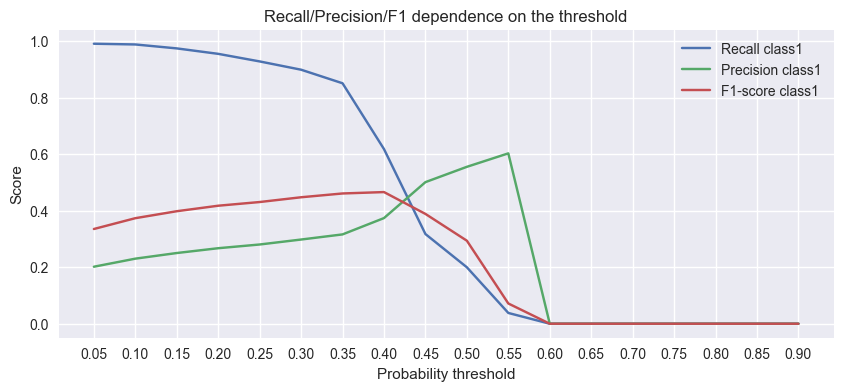

In [ ]:
y_test_pred = model.predict(X_test)


# Ваш код здесь
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0]) # вероятность класса -1
y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1]) # вероятность класса 0
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2]) # вероятность класса 1

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0) # класс 1
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0) # класс -1
y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0) # класс 0

# Инициализируем список, куда будем сохранять метрики.
scores_f1_class1 = []
scores_f1_minus1 = []
scores_f1_zero = []

scores_r_class1 = []
scores_r_minus1 = []
scores_r_zero = []

scores_p_class1 = []
scores_p_minus1 = []
scores_p_zero = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.05, 0.95, 0.05)

# В цикле перебираем значения порогов вероятности

for threshold in tqdm(thresholds):
    # Делаем предсказание
    y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
    y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

    # Рассчитываем метрику
    score_f1_class1 = metrics.f1_score(y_valid_class1, y_test_pred_poly_class1)
    score_p_class1 = metrics.precision_score(y_valid_class1, y_test_pred_poly_class1)
    score_r_class1 = metrics.recall_score(y_valid_class1, y_test_pred_poly_class1)
    scores_f1_class1.append(score_f1_class1)
    scores_r_class1.append(score_r_class1)
    scores_p_class1.append(score_p_class1)

    score_f1_zero = metrics.f1_score(y_valid_zero, y_test_pred_poly_zero)
    score_p_zero = metrics.precision_score(y_valid_zero, y_test_pred_poly_zero)
    score_r_zero = metrics.recall_score(y_valid_zero, y_test_pred_poly_zero)
    scores_f1_zero.append(score_f1_zero)
    scores_r_zero.append(score_r_zero)
    scores_p_zero.append(score_p_zero)
    
    score_f1_minus1 = metrics.f1_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_p_minus1 = metrics.precision_score(y_valid_minus1, y_test_pred_poly_minus1)
    score_r_minus1 = metrics.recall_score(y_valid_minus1, y_test_pred_poly_minus1)    
    scores_f1_minus1.append(score_f1_minus1)
    scores_r_minus1.append(score_r_minus1)
    scores_p_minus1.append(score_p_minus1)

#Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость


# Что-бы не замусоривать график - выведем только класс 1, а остальное закомментируем


#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_minus1, label='Recall minus1')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_minus1, label='Precision minus1')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_minus1, label='F1-score minus1')

#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, scores_r_class1, label='Recall class1')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, scores_p_class1, label='Precision class1')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores_f1_class1, label='F1-score class1')

#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, scores_r_zero, label='Recall zero')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, scores_p_zero, label='Precision zero')
#Строим линейный график зависимости F1 от threshold
#ax.plot(thresholds, scores_f1_zero, label='F1-score zero')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Максимальное значение Precision, которое мы получили - это, примерно, 0.6. При этом общий охват модели уже крайне низкий. Я-бы сказал, что оптимальное значение - это при пороговом значении равным в 0.5 (для класса -1 - оптимальное значение я выбрал 0.45). Посмотрим на метрики при этом значении порогового параметра

In [ ]:
threshold_class1 = 0.5 # выберем порог 0.5 для класса 1
threshold_class_minus1 = 0.45 # выберем порог 0.45 для класса -1

# сделаем предсказание на тестовой выборке, учитывая порог
y_valid_proba_pred_minus1 = pd.Series(model.predict_proba(X_test)[:, 0])
#y_valid_proba_pred_zero = pd.Series(model.predict_proba(X_test)[:, 1])
y_valid_proba_pred_class1 = pd.Series(model.predict_proba(X_test)[:, 2])

y_valid_class1 = y_test.apply(lambda x: 1 if x>0 else 0)
y_valid_minus1 = y_test.apply(lambda x: 1 if x<0 else 0)
#y_valid_zero = y_test.apply(lambda x: 1 if x==0 else 0)

y_test_pred_poly_class1 = y_valid_proba_pred_class1.apply(lambda x: 1 if x > threshold_class1 else 0)
y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold_class_minus1 else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

#y_test_pred_poly_minus1 = y_valid_proba_pred_minus1.apply(lambda x: 1 if x > threshold else 0)
#y_test_pred_poly_zero = y_valid_proba_pred_zero.apply(lambda x: 1 if x > threshold else 0)

y_test_pred = y_test_pred_poly_class1 + y_test_pred_poly_minus1 * -1

# выведем метрики
print(metrics.classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

          -1       0.35      0.07      0.12     88451
           0       0.81      0.98      0.89    586354
           1       0.55      0.19      0.28     91994

    accuracy                           0.78    766799
   macro avg       0.57      0.42      0.43    766799
weighted avg       0.72      0.78      0.72    766799



Изменив пороговое значение, резко снизив охват модели нам удалось серьезно увеличить искомую метрику Precision. Конечно, этого значения (35% для sell-сигнала и 55% для buy-сигнала) недостаточно для экономически успешной модели в данных условиях - но это уже результат, от которого можно отталкиваться.

## 4.5. Learning Curve

Возможно, что данных просто слишком мало для успешного предсказания. Воспользуемся методом Learning Curve, и посмотрим как ведет себя baseline модель в зависимости от количества данных.

In [ ]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    #if ax is None:
    #    fig, ax = plt.subplots(figsize=(15, 10))  # фигура + координатная плоскость    
    fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 0.7)
    # Отображаем легенду
    ax.legend()

Модель у нас уже есть, переходим к построению кривой


c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\trigubov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

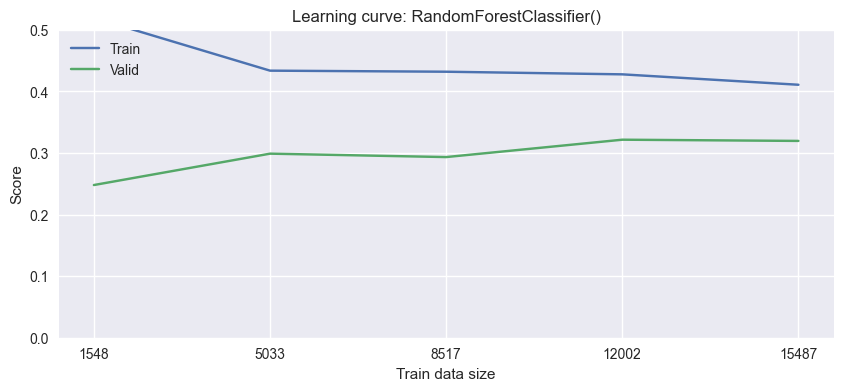

In [ ]:
#Создаем объект кросс-валидатора k-fold
#skf = model_selection.StratifiedKFold(n_splits=10)
kf = model_selection.KFold(n_splits=10, shuffle=False)
#Визуализируем кривые обучения
#fig, axes = plt.subplots(1, 1, figsize=(15, 4))
#Создаем цикл по списку моделей и индексам этого списка

plot_learning_curve(
    model, X_train, y_train, # x_train, y_train
    kf,
    #scoring='f1_macro',
    scoring=score,
    #ax=axes[i],
    title=model.__class__.__name__ + '()'
)

При данной выборке наблюдаем улучшение качества модели в зависимости от количества данных. Но эта выборка у нас уменьшена 1:100. Попробуем сделать тоже самое (без подбора параметров. Их мы пока оставим прежними). Но уменьшив выборку всего в 10 раз, вместо 100

In [ ]:
# загрузим данные из файла
X = pd.read_pickle('pkl/X.pkl')

In [ ]:
# Удалим признаки ask, bid
X.drop(['ask','bid','time'], axis=1, inplace=True)
# разобьем данные на 2 части: обучающую и тестовую
# обучающая часть - это данные за первые 3 недели
# тестовая часть - это данные за последнюю неделю

X_train = X.loc['2023-10-01':'2023-10-21']
X_test = X.loc['2023-10-22':'2023-10-31']
y_train = y.loc['2023-10-01':'2023-10-21']
y_test = y.loc['2023-10-22':'2023-10-31']

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (1720800, 65)
Размер тестовой выборки: (766799, 65)


In [ ]:
# на этот раз уменьшаем не в 100 раз, а в 10
X_train = X_train[::10]
y_train = y_train[::10]

In [ ]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
        min_samples_leaf=88,
        max_depth=4,
        max_features='sqrt',
        n_estimators=399,
        criterion='log_loss',        
        class_weight={-1: 4, 0: 1, 1: 4},
        n_jobs=-1,
        random_state=random_state
)    

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('---train---')
print(metrics.classification_report(y_train, y_train_pred))
print('---test---')
print(metrics.classification_report(y_test, y_test_pred))

---train---
              precision    recall  f1-score   support

          -1       0.36      0.25      0.29     24177
           0       0.95      0.78      0.86    120839
           1       0.38      0.77      0.51     27064

    accuracy                           0.71    172080
   macro avg       0.56      0.60      0.55    172080
weighted avg       0.77      0.71      0.72    172080

---test---
              precision    recall  f1-score   support

          -1       0.27      0.39      0.32     88451
           0       0.94      0.82      0.88    586354
           1       0.35      0.49      0.41     91994

    accuracy                           0.73    766799
   macro avg       0.52      0.57      0.53    766799
weighted avg       0.79      0.73      0.76    766799



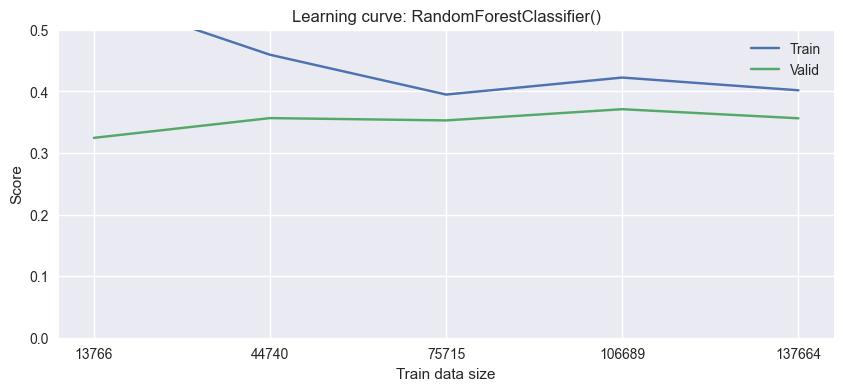

In [ ]:
# снова построим кривую обучения

kf = model_selection.KFold(n_splits=5, shuffle=False)
#Визуализируем кривые обучения
#fig, axes = plt.subplots(1, 1, figsize=(15, 4))
#Создаем цикл по списку моделей и индексам этого списка

plot_learning_curve(
    model, X_train, y_train, # x_train, y_train
    kf,
    scoring=score,    
    title=model.__class__.__name__ + '()'
)

Хорошо видно, что при увеличении количества данных растёт качество модели и падает переобучение. Но при данных свыше 100 тысяч записей - это уже не так заметно.

## 4.6. Важность признаков

Посмотрим на важность признаков baseline модели.

In [ ]:
# Оценим важность признаков:

# Получение важностей признаков
feature_importances = model.feature_importances_

# Сопоставление признаков с их важностями
feature_names = X_train.columns.tolist()  # Список названий ваших признаков
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Вывод важности признаков в упорядоченном виде
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {round(importance*100,3)}")

Feature: time_bol1_300, Importance: 14.868
Feature: time_bol1_1800, Importance: 12.437
Feature: time_std_300, Importance: 12.091
Feature: time_std_1800, Importance: 11.5
Feature: time_bol1_60, Importance: 6.012
Feature: time_std_60, Importance: 5.174
Feature: time_bol1_7200, Importance: 4.531
Feature: time_std_7200, Importance: 3.66
Feature: bid_std_5, Importance: 2.733
Feature: ask_std_7200, Importance: 2.714
Feature: time_bol1_5, Importance: 2.602
Feature: time_std_5, Importance: 2.387
Feature: ask_std_5, Importance: 1.927
Feature: time_bol2_1800, Importance: 1.657
Feature: bid_std_7200, Importance: 1.438
Feature: bid_std_1800, Importance: 1.375
Feature: time_bol2_300, Importance: 1.338
Feature: ask_std_60, Importance: 1.27
Feature: bid_std_300, Importance: 1.261
Feature: rsi_60, Importance: 1.175
Feature: bid_std_60, Importance: 1.132
Feature: ask_std_1800, Importance: 0.945
Feature: rsi_1800, Importance: 0.815
Feature: rsi_300, Importance: 0.719
Feature: time_bol2_60, Importance: 0

Интересно, что самыми важными данными модель считает даже не сами Ask-Bid, а данные о количестве сделок (time). Попробуем, в дальнейшем, учесть эти данные.
